In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from utils.vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [4]:
plt.show()
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in"})


In [5]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

In [6]:
# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


In [7]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

In [62]:
# functions to get the primaries and secondaries based on AM mass
def get_primaries(sim, phys, size, z, key="Sub1 Mass", median=False):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_100.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    # get data for unpaired halos first
    unpaired = pair_data["unpaired"][phys]
    unpaired_stells = np.array(unpaired["Sub1 Stellar Mass"])
    # get data for paired halos next
    paired = pair_data["pairs"][phys]
    paired_stells = np.array(paired["Sub1 Stellar Mass"])
    
    # masks
    unpaired_prims = get_primmask(unpaired_stells, size)
    unpaired_group = get_groupmask(np.array(unpaired["Group Mass"]), size)
    unpaired_median = np.array( unpaired['Realization'] ) ==-1
    paired_prims = get_primmask(paired_stells, size)
    paired_group = get_groupmask(np.array(paired["Group Mass"]), size)
    paired_median = np.array( paired['Realization'] ) ==-1
    
    unpaired_mask = unpaired_prims & unpaired_group 
    paired_mask = paired_prims & paired_group 
    
    if median:
        unpaired_mask = unpaired_prims & unpaired_median
        paired_mask = paired_prims & paired_median
        
    unpaired_key = np.array(unpaired[key])[unpaired_mask]    
    paired_key = np.array(paired[key])[paired_mask]

    catkey = np.concatenate((unpaired_key,paired_key))

    return catkey


In [106]:
# functions to get the primaries and secondaries based on AM mass
def get_majmin(sim, phys, size, z, key="Sub1 Mass", median=False, **kwargs):
    zloc = np.where( zs['z'] == z)[0]
    minn = kwargs.pop("min",10)
    maxx = kwargs.pop("max",1000)
    sepmask = kwargs.pop("sepmask","default")
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_100.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    grouprads = np.array(pairs["Group Radius"])
    seps = np.array(pairs["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs["Group Mass"]), size)
    pair_medreal = np.array( pairs['Realization'] ) == -1
    pair_sepcut = (seps > 10) & (seps <10000)

    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_sepcut
        
    major_mask = pair_mask & majors & pair_group
    minor_mask = pair_mask & minors & pair_group
        
    if median: 
        major_mask = major_mask & pair_medreal
        minor_mask = minor_mask & pair_medreal
    
    major_key = np.array(pairs[key])[major_mask]
    minor_key = np.array(pairs[key])[minor_mask]
    
    pair_dict = {"majors":major_key, "minors":minor_key}
        
    return pair_dict

# functions to get the primaries and secondaries based on AM mass
def get_scaledsep(sim, phys, z, median=False):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_100.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    grouprads = np.array(pairs["Group Radius"])
    seps = np.array(pairs["Separation"]) 

    # masks            
    dwarf_pri = get_primmask(pri_stell, "dwarf")
    dwarf_gr = get_groupmask(np.array(pairs["Group Mass"]), "dwarf")
    massive_pri = get_primmask(pri_stell, "massive")
    massive_gr = get_groupmask(np.array(pairs["Group Mass"]), "massive")
    
    pair_medreal = np.array( pairs['Realization'] ) == -1
    pair_sepcut = (seps > 10) & (seps <10000)

    majors = (sec_stell/pri_stell > 1/4)

    majsep = majors & pair_sepcut
        
    dwarf_mask = dwarf_pri & dwarf_gr & majsep
    massive_mask = massive_pri & massive_gr & majsep
        
    if median: 
        dwarf_mask = dwarf_mask & pair_medreal
        massive_mask = massive_mask & pair_medreal
    
    dwarf_sep = (seps/grouprads)[dwarf_mask]
    massive_sep = (seps/grouprads)[massive_mask]
    
    pair_dict = {"dwarf":dwarf_sep, "massive":massive_sep}
        
    return pair_dict



# Dwarf all

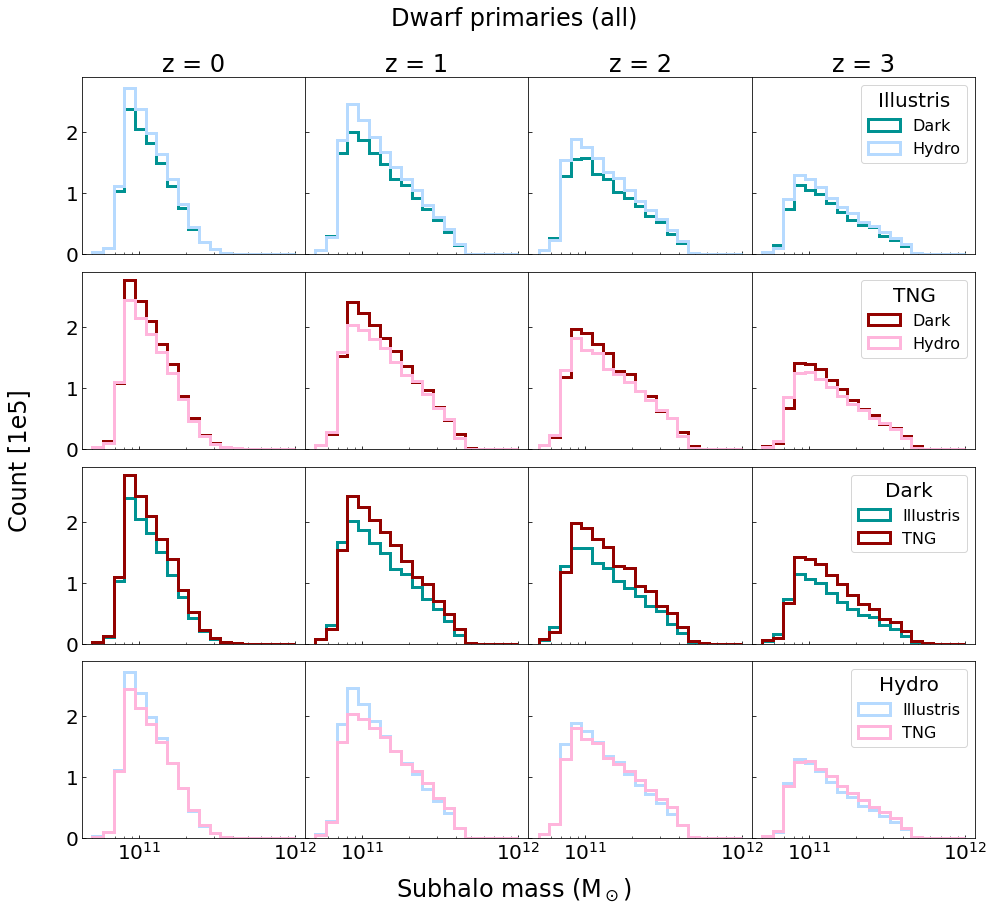

In [54]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.7,12,20)
weight = 100000
key = "Sub1 Mass"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = get_primaries("Illustris","dark", size, i, key)*1e10
    illh = get_primaries("Illustris","hydro", size, i, key)*1e10
    
    tngd = get_primaries("TNG","dark", size, i, key)*1e10
    tngh = get_primaries("TNG","hydro", size, i, key)*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf primaries (all)",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [1e5]",x=0.060)

plt.savefig(f"../plots/massdist_dwarf_all.png",bbox_inches='tight',facecolor="white")
plt.show()

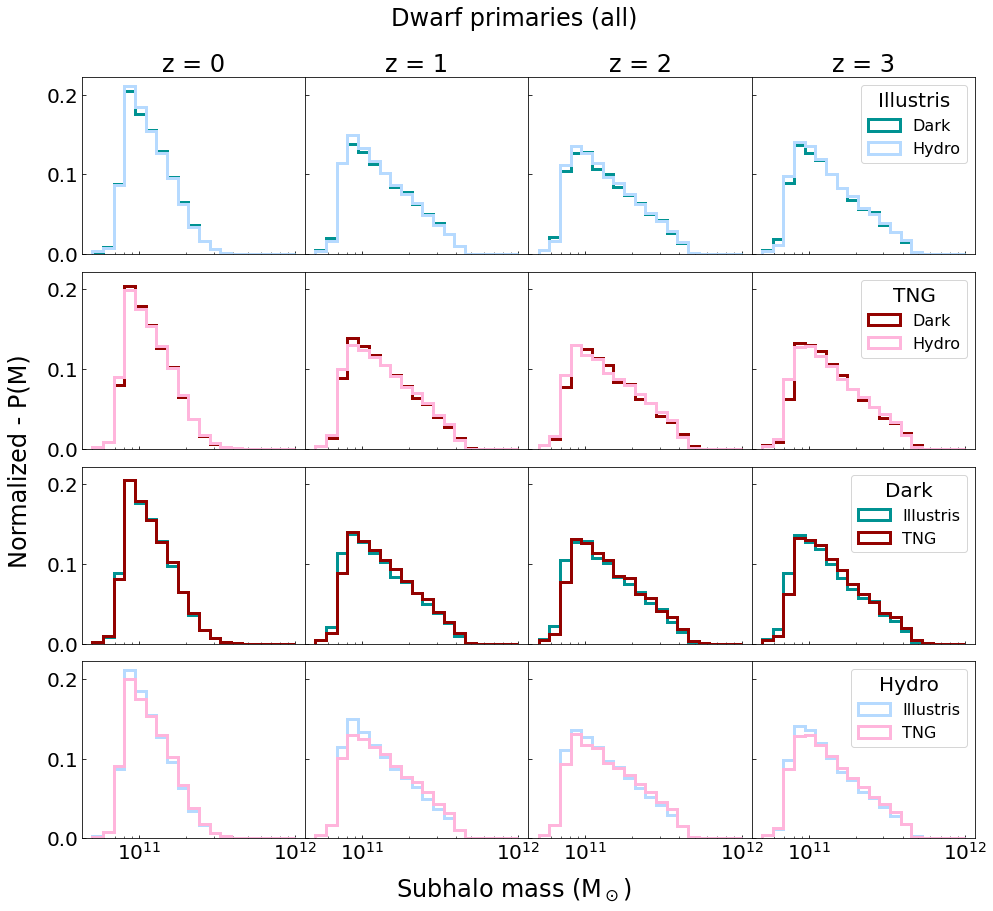

In [55]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.7,12,20)
weight = 1
key = "Sub1 Mass"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = get_primaries("Illustris","dark", size, i, key)*1e10
    illh = get_primaries("Illustris","hydro", size, i, key)*1e10
    
    tngd = get_primaries("TNG","dark", size, i, key)*1e10
    tngh = get_primaries("TNG","hydro", size, i, key)*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf primaries (all)",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Normalized - P(M)",x=0.060)

plt.savefig(f"../plots/massdistnorm_dwarf_all.png",bbox_inches='tight',facecolor="white")
plt.show()

# Massive all 

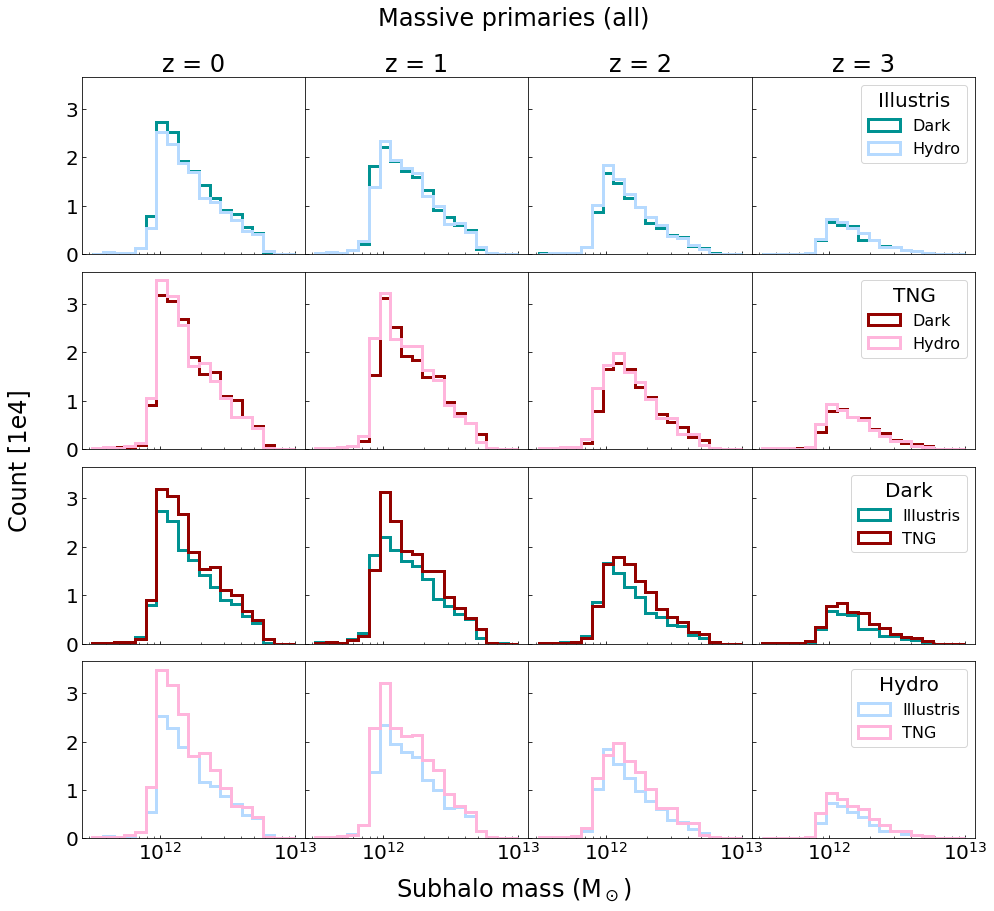

In [73]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(11.5,13,20)
weight = 1e4
key = "Sub1 Mass"
size = "massive"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = get_primaries("Illustris","dark", size, i, key)*1e10
    illh = get_primaries("Illustris","hydro", size, i, key)*1e10
    
    tngd = get_primaries("TNG","dark", size, i, key)*1e10
    tngh = get_primaries("TNG","hydro", size, i, key)*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Massive primaries (all)",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [1e4]",x=0.060)

plt.savefig(f"../plots/massdist_massive_all.png",bbox_inches='tight',facecolor="white")
plt.show()

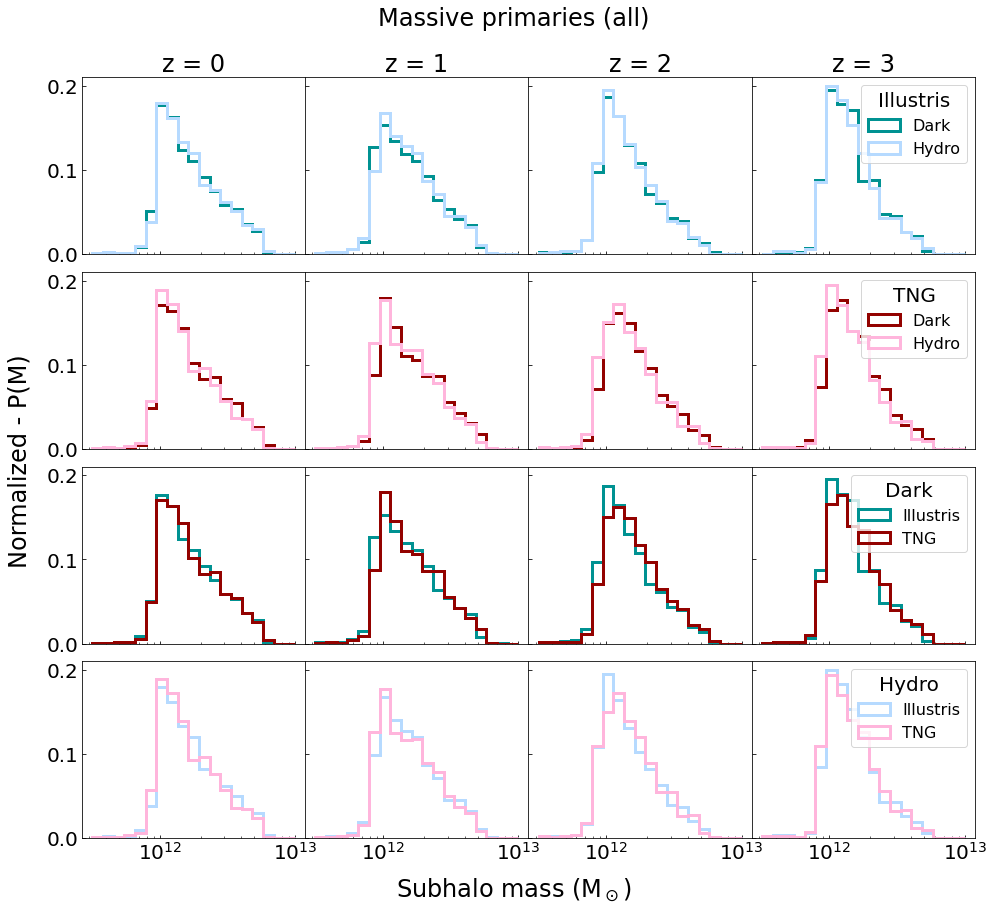

In [57]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(11.5,13,20)
weight = 1
key = "Sub1 Mass"
size = "massive"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = get_primaries("Illustris","dark", size, i, key)*1e10
    illh = get_primaries("Illustris","hydro", size, i, key)*1e10
    
    tngd = get_primaries("TNG","dark", size, i, key)*1e10
    tngh = get_primaries("TNG","hydro", size, i, key)*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Massive primaries (all)",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Normalized - P(M)",x=0.060)

plt.savefig(f"../plots/massdistnorm_massive_all.png",bbox_inches='tight',facecolor="white")
plt.show()

# Dwarf major pairs

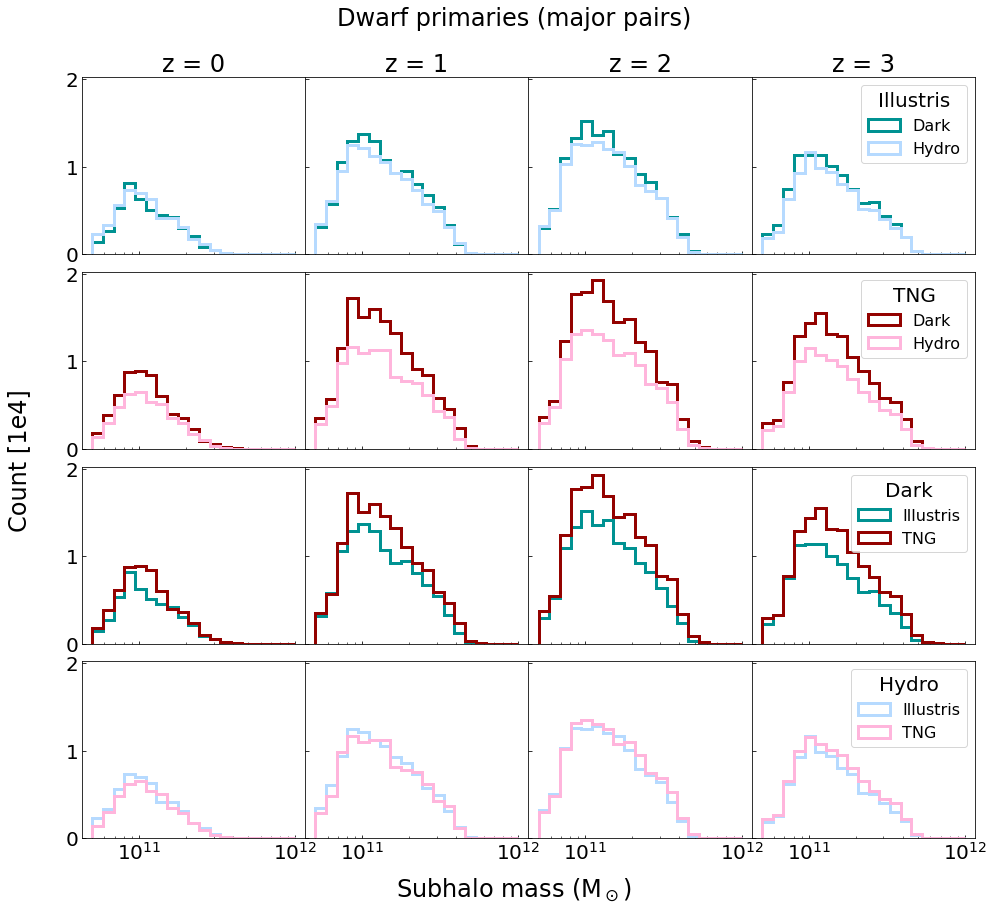

In [67]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.7,12,20)
weight = 1e4
key = "Sub1 Mass"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = np.array(get_majmin("Illustris","dark", size, i, key)['majors'])*1e10
    illh = np.array(get_majmin("Illustris","hydro", size, i, key)['majors'])*1e10
    
    tngd = np.array(get_majmin("TNG","dark", size, i, key)['majors'])*1e10
    tngh = np.array(get_majmin("TNG","hydro", size, i, key)['majors'])*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf primaries (major pairs)",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [1e4]",x=0.060)

plt.savefig(f"../plots/massdist_dwarf_major.png",bbox_inches='tight',facecolor="white")
plt.show()

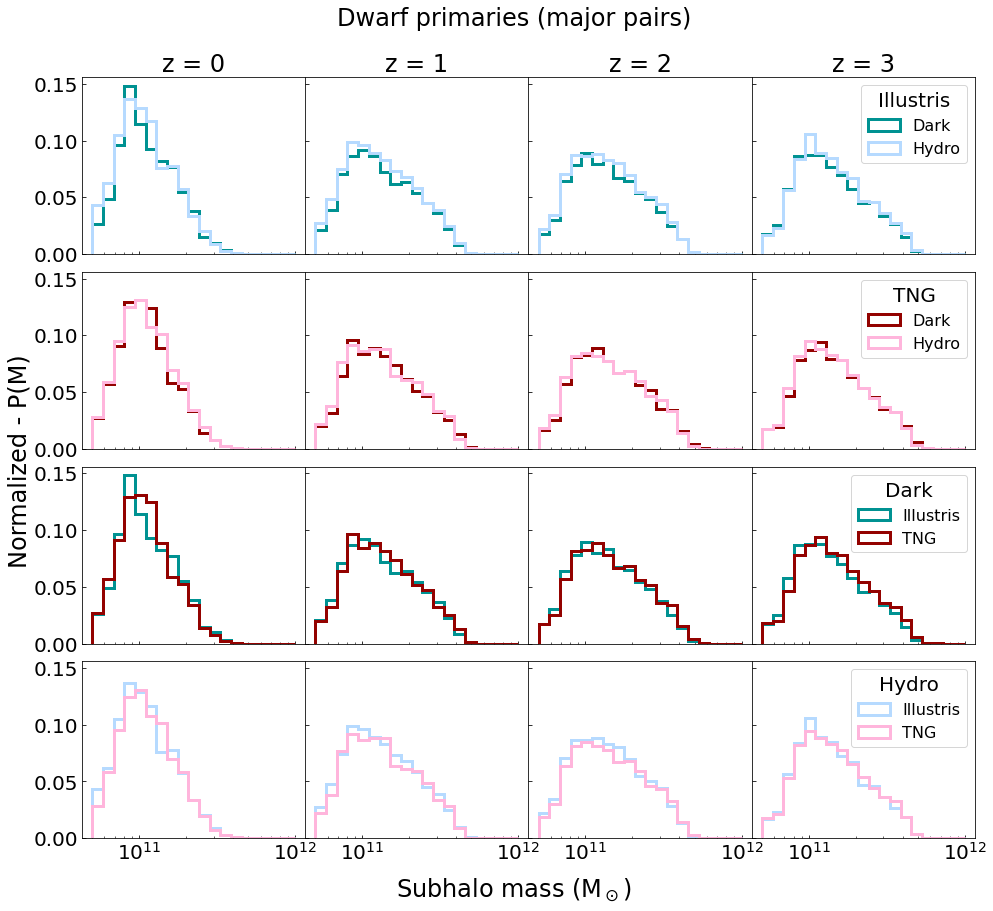

In [70]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.7,12,20)
weight = 1
key = "Sub1 Mass"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = np.array(get_majmin("Illustris","dark", size, i, key)['majors'])*1e10
    illh = np.array(get_majmin("Illustris","hydro", size, i, key)['majors'])*1e10
    
    tngd = np.array(get_majmin("TNG","dark", size, i, key)['majors'])*1e10
    tngh = np.array(get_majmin("TNG","hydro", size, i, key)['majors'])*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf primaries (major pairs)",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Normalized - P(M)",x=0.060)

plt.savefig(f"../plots/massdistnorm_dwarf_major.png",bbox_inches='tight',facecolor="white")
plt.show()

# Massive major pairs

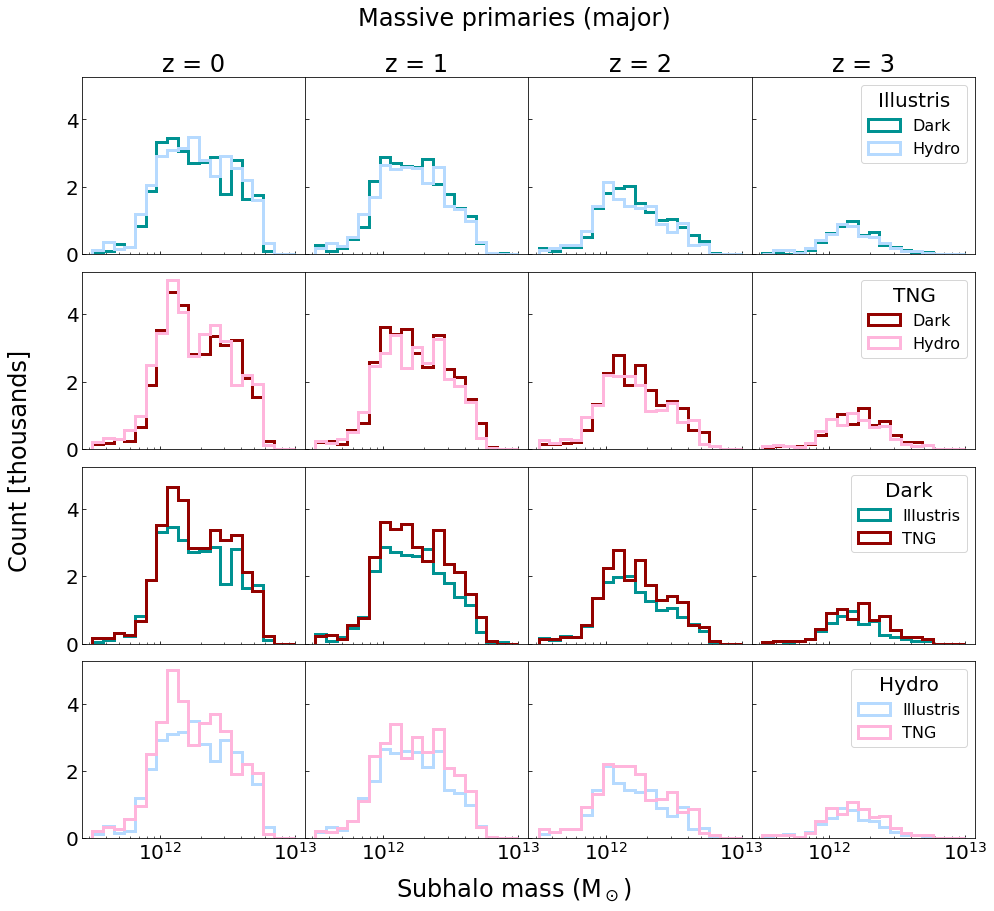

In [77]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(11.5,13,20)
weight = 1000
key = "Sub1 Mass"
size = "massive"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = np.array(get_majmin("Illustris","dark", size, i, key)['majors'])*1e10
    illh = np.array(get_majmin("Illustris","hydro", size, i, key)['majors'])*1e10
    
    tngd = np.array(get_majmin("TNG","dark", size, i, key)['majors'])*1e10
    tngh = np.array(get_majmin("TNG","hydro", size, i, key)['majors'])*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Massive primaries (major)",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/massdist_massive_major.png",bbox_inches='tight',facecolor="white")
plt.show()

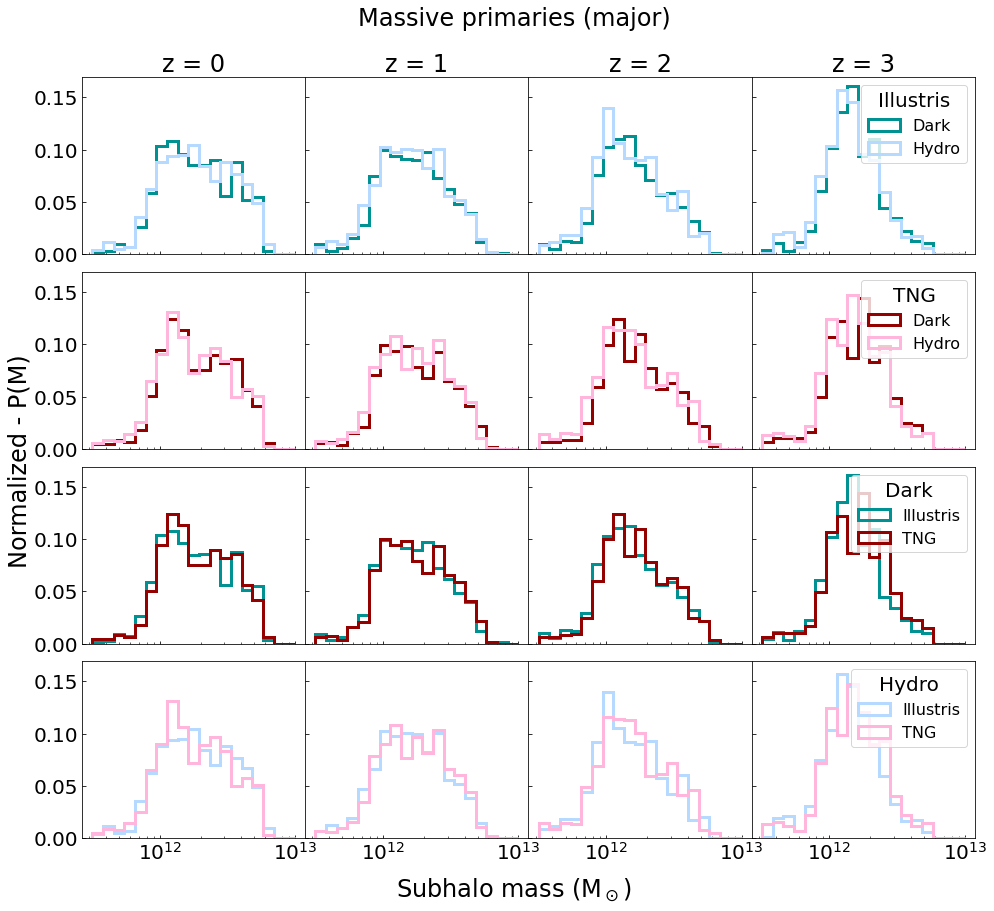

In [78]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(11.5,13,20)
weight = 1
key = "Sub1 Mass"
size = "massive"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = np.array(get_majmin("Illustris","dark", size, i, key)['majors'])*1e10
    illh = np.array(get_majmin("Illustris","hydro", size, i, key)['majors'])*1e10
    
    tngd = np.array(get_majmin("TNG","dark", size, i, key)['majors'])*1e10
    tngh = np.array(get_majmin("TNG","hydro", size, i, key)['majors'])*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Massive primaries (major)",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Normalized - P(M)",x=0.060)

plt.savefig(f"../plots/massdistnorm_massive_major.png",bbox_inches='tight',facecolor="white")
plt.show()

# Dwarf sep dist - major

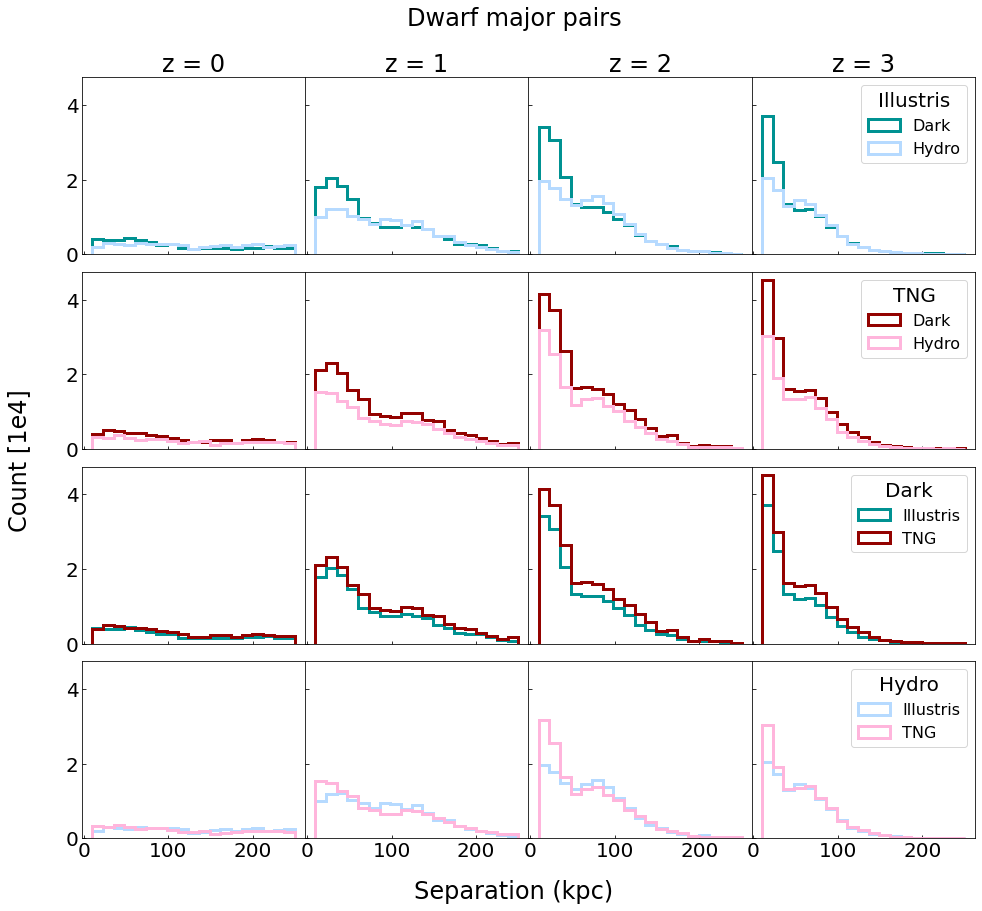

In [86]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
# bins = np.logspace(10.7,12,20)
bins = np.linspace(10,250,20)
weight = 1e4
key = "Separation"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
#     ax[0][i].set_xscale('log')

    illd = np.array(get_majmin("Illustris","dark", size, i, key)['majors'])
    illh = np.array(get_majmin("Illustris","hydro", size, i, key)['majors'])
    
    tngd = np.array(get_majmin("TNG","dark", size, i, key)['majors'])
    tngh = np.array(get_majmin("TNG","hydro", size, i, key)['majors'])
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf major pairs",y=0.95)
fig.supxlabel(r"Separation (kpc)",y=0.06)
fig.supylabel("Count [1e4]",x=0.060)

plt.savefig(f"../plots/sepdist_dwarf_major.png",bbox_inches='tight',facecolor="white")
plt.show()

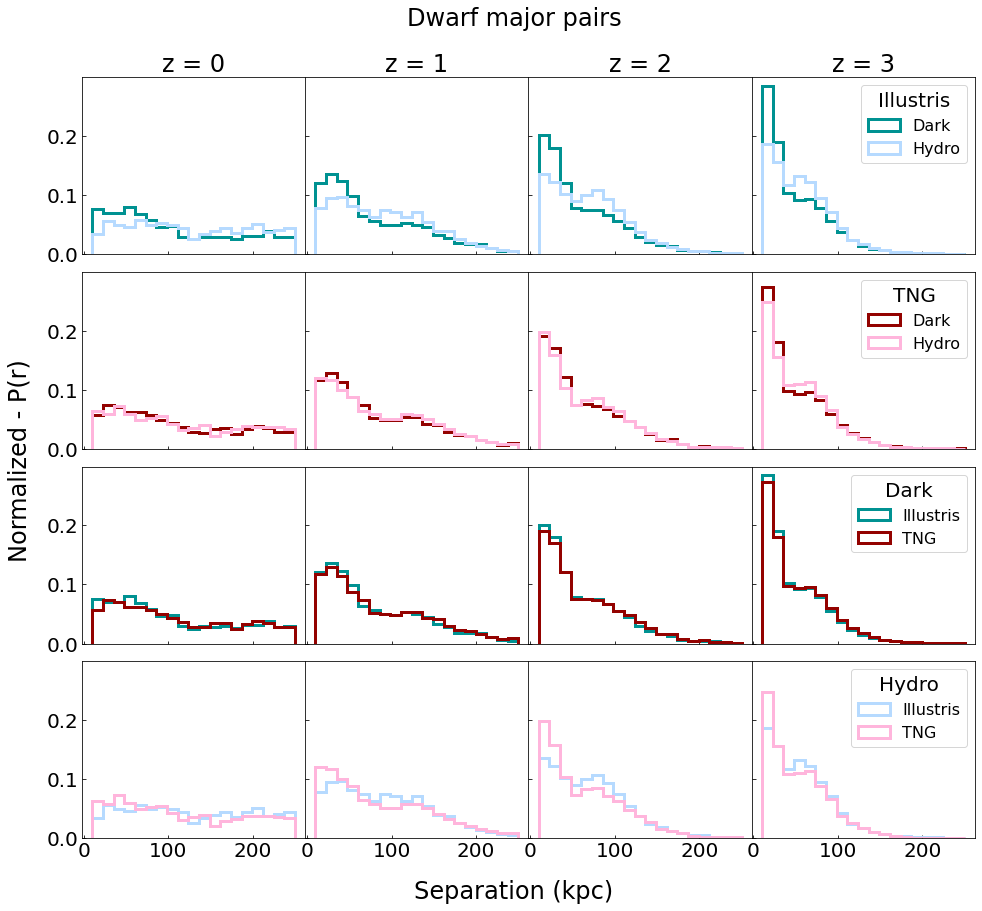

In [95]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.linspace(10,250,20)
weight = 1
key = "Separation"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
#     ax[0][i].set_xscale('log')

    illd = np.array(get_majmin("Illustris","dark", size, i, key)['majors'])
    illh = np.array(get_majmin("Illustris","hydro", size, i, key)['majors'])
    
    tngd = np.array(get_majmin("TNG","dark", size, i, key)['majors'])
    tngh = np.array(get_majmin("TNG","hydro", size, i, key)['majors'])
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf major pairs",y=0.95)
fig.supxlabel(r"Separation (kpc)",y=0.06)
fig.supylabel("Normalized - P(r)",x=0.060)

plt.savefig(f"../plots/sepdistnorm_dwarf_major.png",bbox_inches='tight',facecolor="white")
plt.show()

# Massive sep dist - major

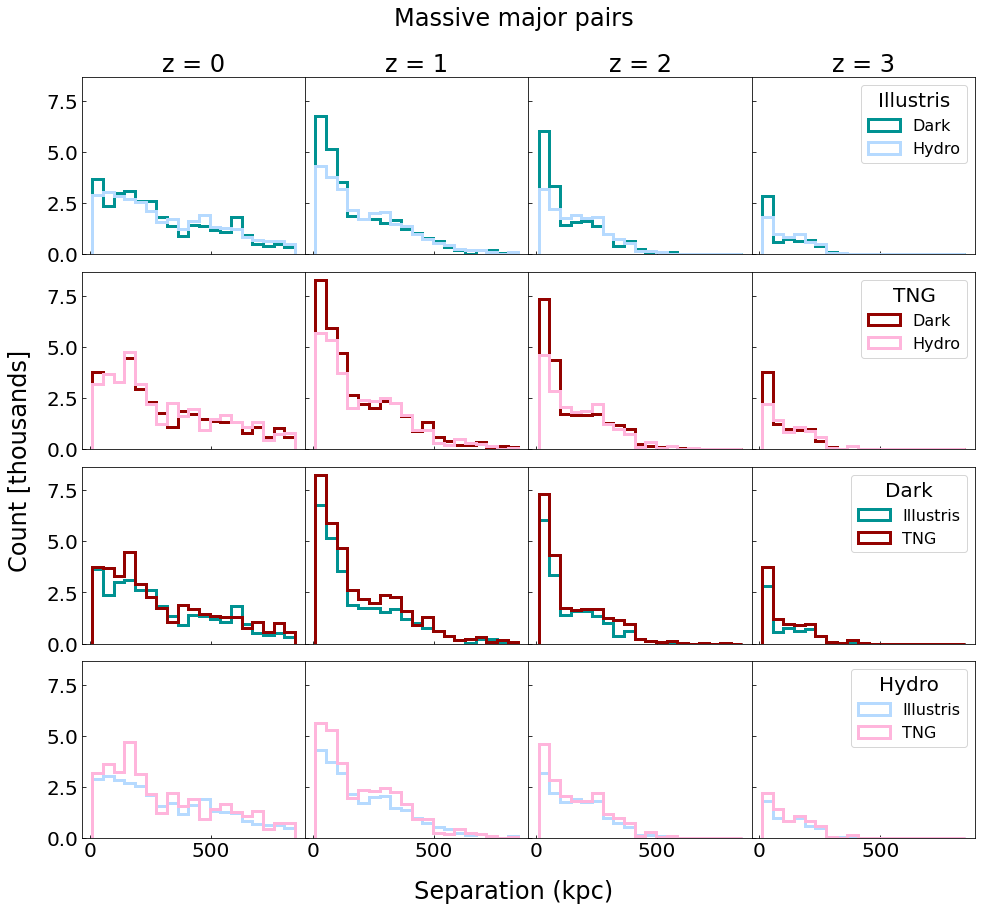

In [102]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.linspace(10,850,20)
weight = 1000
key = "Separation"
size = "massive"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    
    illd = np.array(get_majmin("Illustris","dark", size, i, key)['majors'])
    illh = np.array(get_majmin("Illustris","hydro", size, i, key)['majors'])
    
    tngd = np.array(get_majmin("TNG","dark", size, i, key)['majors'])
    tngh = np.array(get_majmin("TNG","hydro", size, i, key)['majors'])
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Massive major pairs",y=0.95)
fig.supxlabel(r"Separation (kpc)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/sepdist_massive_major.png",bbox_inches='tight',facecolor="white")
plt.show()

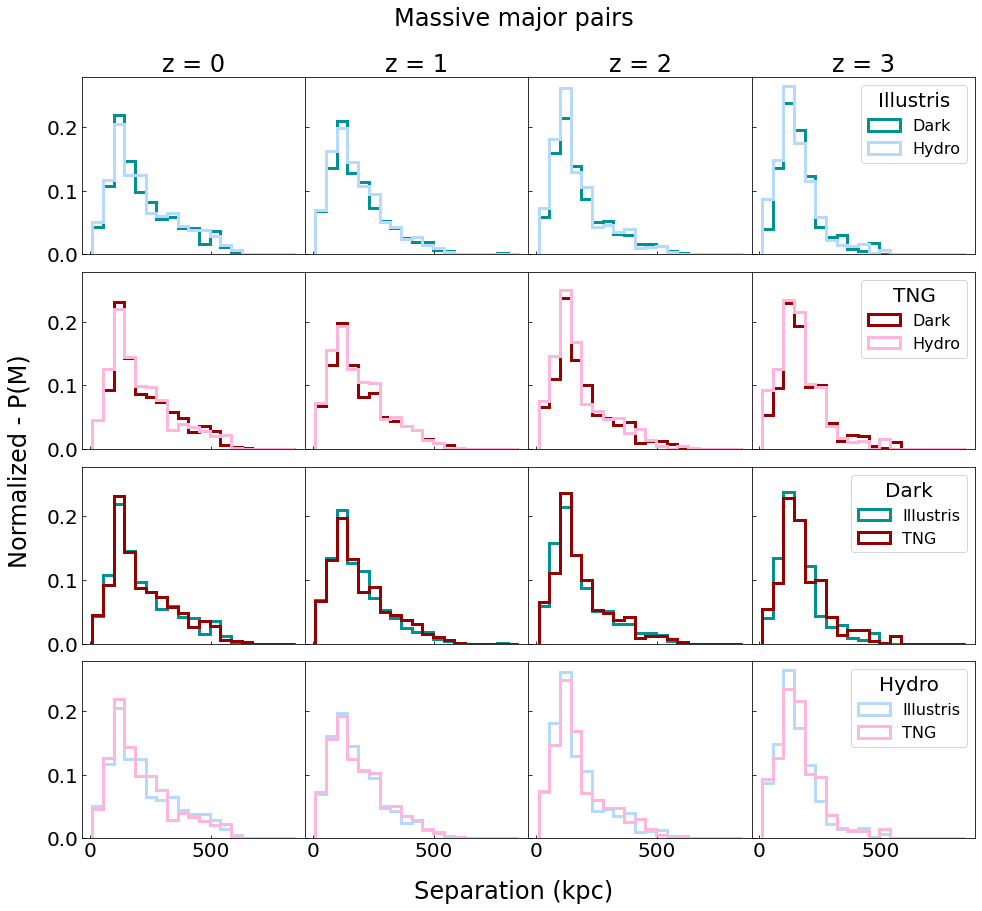

In [105]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.linspace(10,850,20)
weight = 1
key = "Sub1 Mass"
size = "massive"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")

    illd = np.array(get_majmin("Illustris","dark", size, i, key)['majors'])
    illh = np.array(get_majmin("Illustris","hydro", size, i, key)['majors'])
    
    tngd = np.array(get_majmin("TNG","dark", size, i, key)['majors'])
    tngh = np.array(get_majmin("TNG","hydro", size, i, key)['majors'])
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Massive major pairs",y=0.95)
fig.supxlabel(r"Separation (kpc)",y=0.06)
fig.supylabel("Normalized - P(M)",x=0.060)

plt.savefig(f"../plots/sepdistnorm_massive_major.png",bbox_inches='tight',facecolor="white")
plt.show()

# Scaled separations

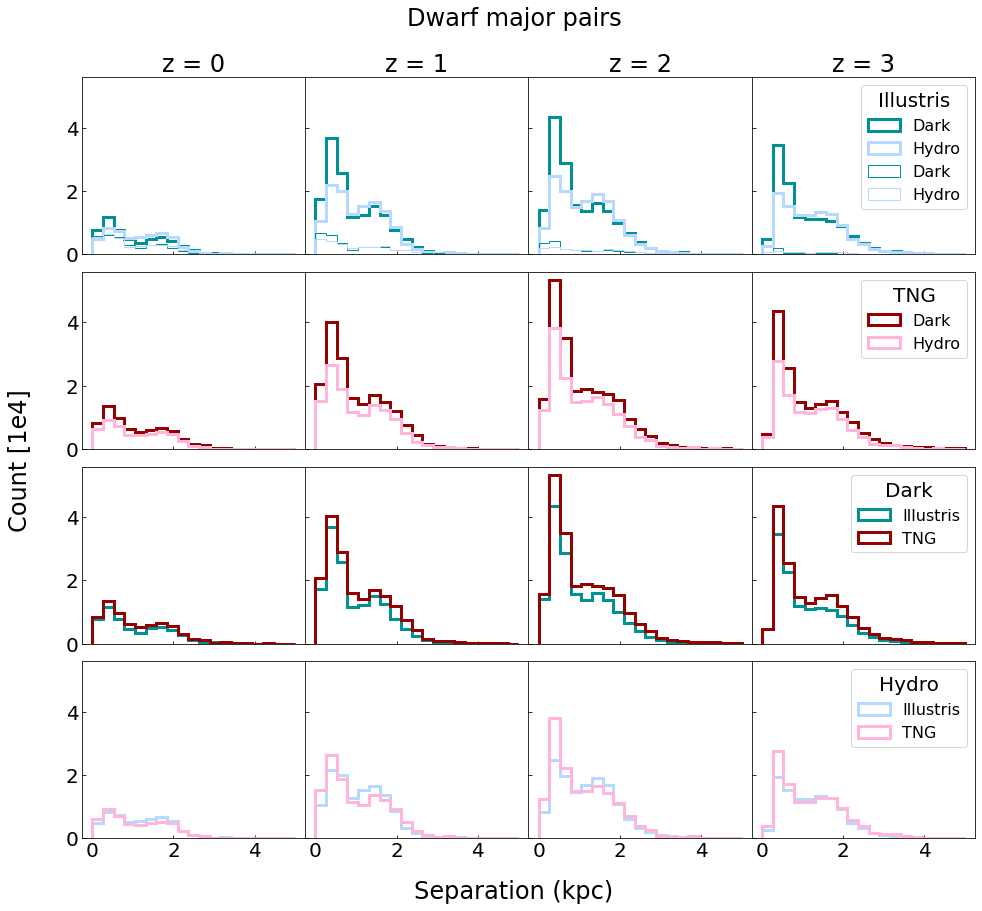

In [111]:

# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
# bins = np.logspace(10.7,12,20)
bins = np.linspace(0,5,20)
weight = 1e4
key = "Separation"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")

    illd = np.array(get_scaledsep("Illustris", "dark", i, median=False)['dwarf'])
    illh = np.array(get_scaledsep("Illustris", "hydro", i, median=False)['dwarf'])
    illmd = np.array(get_scaledsep("Illustris", "dark", i, median=False)['massive'])
    illmh = np.array(get_scaledsep("Illustris", "hydro", i, median=False)['massive'])
    
    tngd = np.array(get_scaledsep("TNG", "dark", i, median=False)['dwarf'])
    tngh = np.array(get_scaledsep("TNG", "hydro", i, median=False)['dwarf'])
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    ill[i].hist(illmd, weights=np.ones(len(illmd))/weight, bins=bins, histtype='step', lw=1, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illmh, weights=np.ones(len(illmh))/weight, bins=bins, histtype='step', lw=1, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf major pairs",y=0.95)
fig.supxlabel(r"Separation (kpc)",y=0.06)
fig.supylabel("Count [1e4]",x=0.060)

# plt.savefig(f"../plots/sepdist_dwarf_major.png",bbox_inches='tight',facecolor="white")
plt.show()

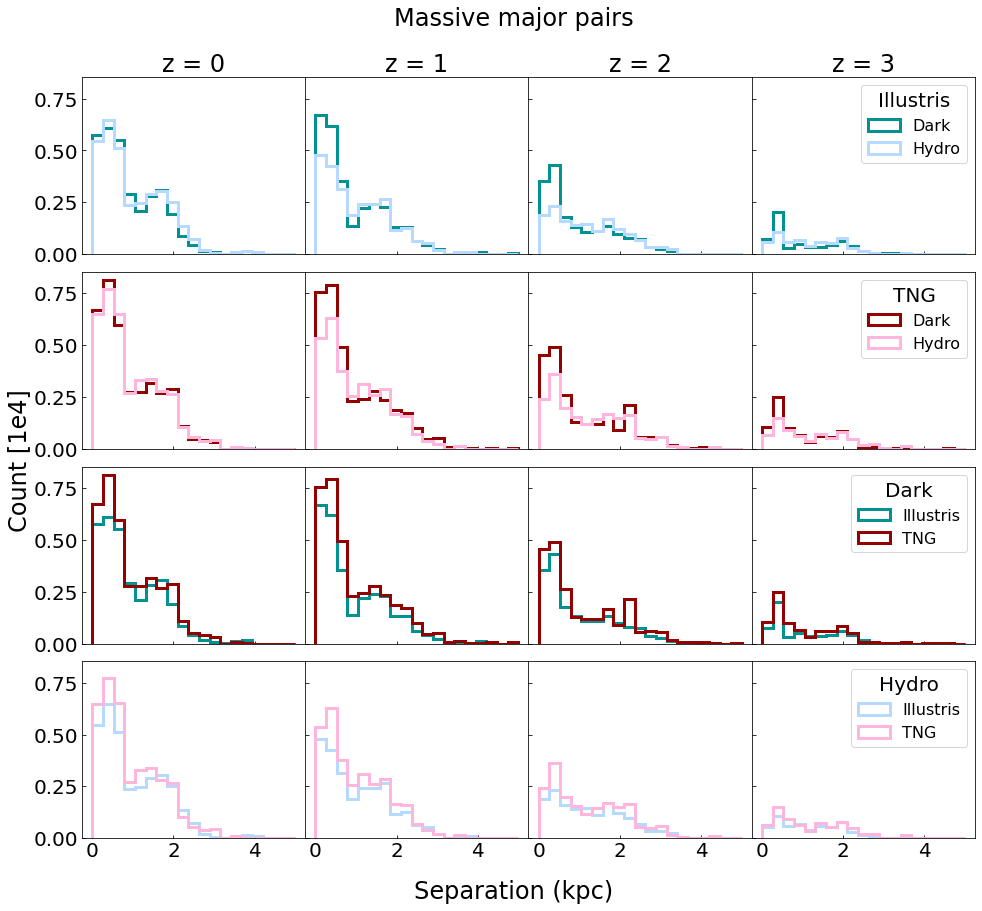

In [110]:

# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
# bins = np.logspace(10.7,12,20)
bins = np.linspace(0,5,20)
weight = 1e4
key = "Separation"
size = "massive"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")

    illd = np.array(get_scaledsep("Illustris", "dark", i, median=False)[size])
    illh = np.array(get_scaledsep("Illustris", "hydro", i, median=False)[size])
    
    tngd = np.array(get_scaledsep("TNG", "dark", i, median=False)[size])
    tngh = np.array(get_scaledsep("TNG", "hydro", i, median=False)[size])
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Massive major pairs",y=0.95)
fig.supxlabel(r"Separation (kpc)",y=0.06)
fig.supylabel("Count [1e4]",x=0.060)

# plt.savefig(f"../plots/sepdist_dwarf_major.png",bbox_inches='tight',facecolor="white")
plt.show()

## median

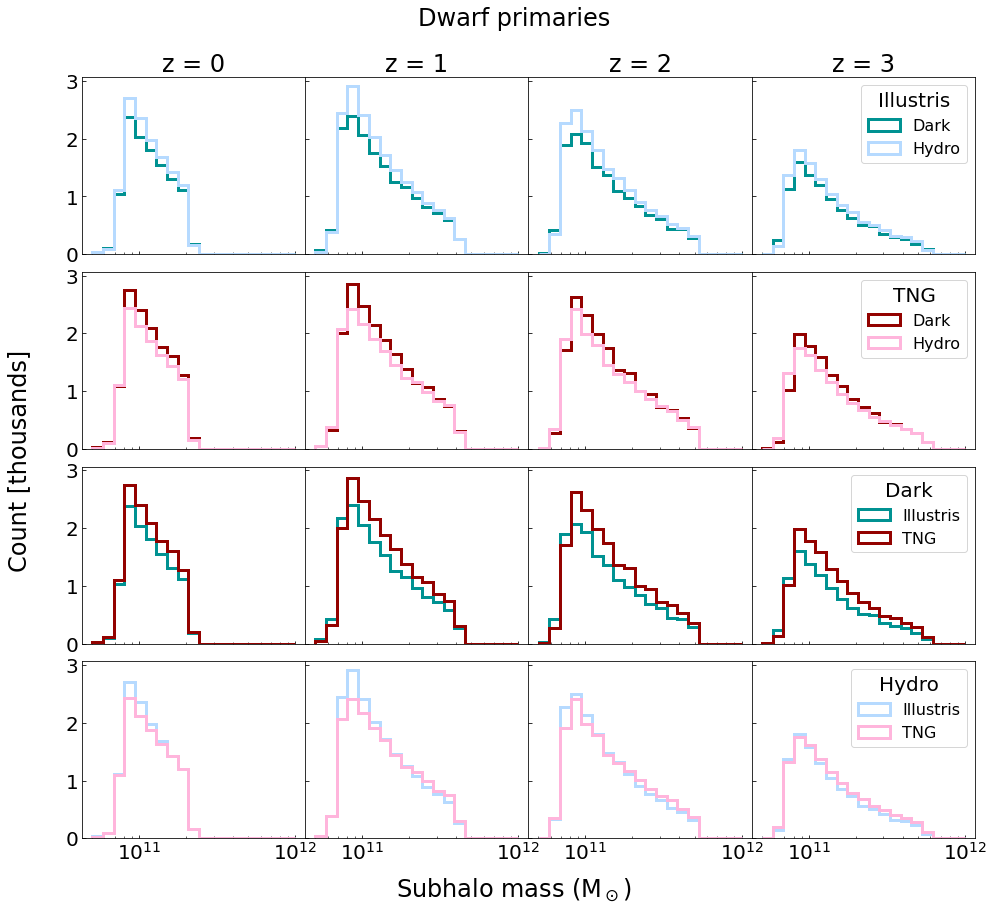

In [39]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.7,12,20)
weight = 1000
key = "Sub1 Mass"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = get_primaries("Illustris","dark", size, i, key, median=True)*1e10
    illh = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10
    
    tngd = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    tngh = get_primaries("TNG","hydro", size, i, key, median=True)*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/weight, bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/weight, bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf primaries",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

# plt.savefig(f"../plots/distributions/Mh_med_d1.png",bbox_inches='tight',facecolor="white")
plt.show()

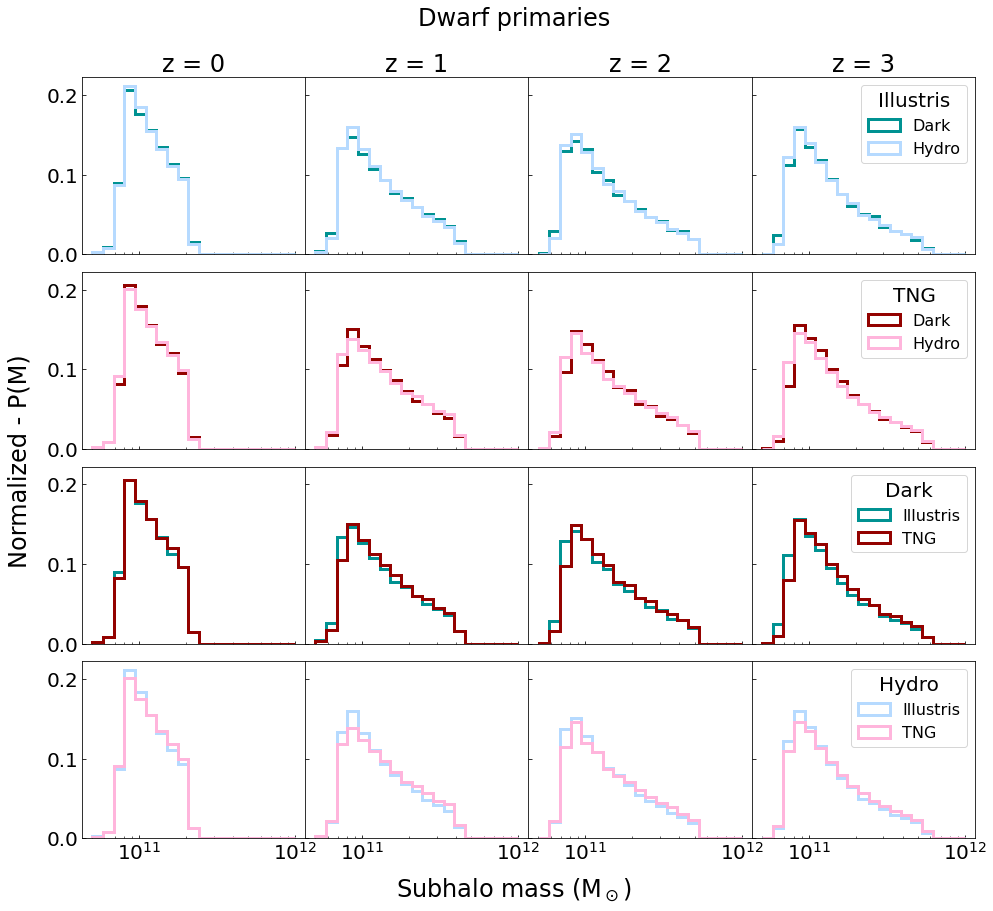

In [38]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.7,12,20)
weight = 1
key = "Sub1 Mass"
size = "dwarf"

ill = ax[0]
tng = ax[1]
dark = ax[2]
hydro = ax[3]

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    illd = get_primaries("Illustris","dark", size, i, key, median=True)*1e10
    illh = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10
    
    tngd = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    tngh = get_primaries("TNG","hydro", size, i, key, median=True)*1e10
    
        # illustris d v h 
    ill[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Dark')
    ill[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Hydro')
    
        # tng d v h
    tng[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='Dark')
    tng[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='Hydro')
    
        # dark ill v tng
    dark[i].hist(illd, weights=np.ones(len(illd))/len(illd), bins=bins, histtype='step', lw=3, color=palette['Illustris dark'],label='Illustris')
    dark[i].hist(tngd, weights=np.ones(len(tngd))/len(tngd), bins=bins, histtype='step', lw=3, color=palette['TNG dark'],label='TNG')
    
        # hydro ill v tng
    hydro[i].hist(illh, weights=np.ones(len(illh))/len(illh), bins=bins, histtype='step', lw=3, color=palette['Illustris hydro'],label='Illustris')
    hydro[i].hist(tngh, weights=np.ones(len(tngh))/len(tngh), bins=bins, histtype='step', lw=3, color=palette['TNG hydro'],label='TNG')

ill[3].legend(title="Illustris",fontsize=16)
tng[3].legend(title="TNG",fontsize=16)
dark[3].legend(title="Dark",fontsize=16)
hydro[3].legend(title="Hydro",fontsize=16)

fig.suptitle("Dwarf primaries",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Normalized - P(M)",x=0.060)

# plt.savefig(f"../plots/distributions/Mh_med_d1.png",bbox_inches='tight',facecolor="white")
plt.show()